## Import packages

In [1]:
import os, glob
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import pickle
import json
import csv
#import yaml

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from tensorflow.keras import callbacks
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.activations import relu
from tensorflow.keras.optimizers import SGD
import tensorflow_addons as tfa
from qhoptim.tf import QHAdamOptimizer

from tqdm import tqdm

import matplotlib.pyplot as plt

2023-11-25 20:04:33.665513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 20:04:43.203599: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 20:05:01.629334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 20:05:01.629818: W tensorflow/stream_executor/

In [2]:
!pwd

/ocean/projects/atm200007p/jlin96/ams_talk/baseline/coupling_folder


## Summarize trial.json

In [126]:
proj_name = 'baseline'
tuning_dir = '../training/tuning_directory/' + proj_name + "/"
trial_root = os.path.join(tuning_dir, 'trial_*')
trial_paths = sorted(glob.glob(trial_root))

tuning_dict = {}
for trial_path in trial_paths:
    trial_id = trial_path.split('/')[-1]
    json_path = trial_path + '/trial.json'
    with open(json_path) as f:
        trial_data = json.load(f)
    tuning_dict[trial_id] = {}
    hp_values = trial_data['hyperparameters']['values']
    for hp_name, hp_value in hp_values.items():
        tuning_dict[trial_id][hp_name] = hp_value
    tuning_dict[trial_id]['min_val_loss'] = trial_data['metrics']['metrics']['val_mse']['observations'][0]['value'][0]

tuning_df = pd.DataFrame.from_dict(tuning_dict, orient = 'index')
tuning_df.rename_axis('trial_id', inplace=True)
pandas_path = 'RESULTS_' + proj_name + '.pandas.pkl'
tuning_df.to_pickle(pandas_path)


tuning_df_sorted = tuning_df.sort_values(by=['min_val_loss'])
tuning_df_sorted.reset_index(inplace = True)
tuning_df_sorted.index = pd.RangeIndex(tuning_df_sorted.index.start+1, tuning_df_sorted.index.stop+1)
tuning_df_sorted.rename_axis('rank', inplace=True)
pandas_sorted_path = 'RESULTS_' + proj_name + '_sorted.pandas.pkl'
tuning_df_sorted.to_pickle(pandas_sorted_path)


## Plot min val loss

/tmp/ipykernel_29085/791446714.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tuning_df_sorted['min_val_loss'][0:80].plot(ax=axes[1])


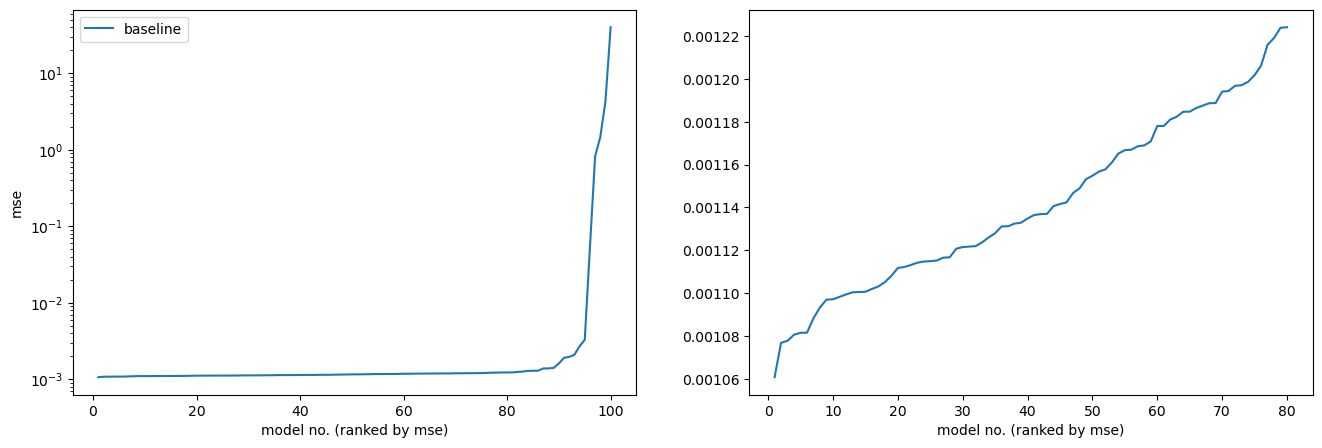

In [130]:
fig, axes =  plt.subplots(ncols=2)

tuning_df_sorted['min_val_loss'].plot(ax = axes[0], label = proj_name)
axes[0].set_yscale('log')
axes[0].set_ylabel('mse')
axes[0].set_xlabel('model no. (ranked by mse)')
axes[0].legend()

tuning_df_sorted['min_val_loss'][0:80].plot(ax=axes[1])

axes[1].set_xlabel('model no. (ranked by mse)')
fig.set_size_inches(16,5)

# Load weight to save h5 model files

In [135]:
tuning_df_sorted.loc[1].to_dict()

{'trial_id': 'trial_079',
 'leak': 0.3993848052367777,
 'dropout': 0.008372449277113975,
 'lr': 6.842976469237976e-05,
 'hidden_units': 436,
 'num_layers': 5,
 'optimizer': 'adam',
 'batch_normalization': False,
 'min_val_loss': 0.0010607227450236678}

In [140]:
def build_model(hp:dict):
    alpha = hp["leak"]
    dp_rate = hp["dropout"]
    batch_norm = hp["batch_normalization"]
    model = Sequential()
    hiddenUnits = hp['hidden_units']
    model.add(Dense(units = hiddenUnits, input_dim=185, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha = alpha))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dp_rate))
    for i in range(hp["num_layers"]):
        model.add(Dense(units = hiddenUnits, kernel_initializer='normal'))
        model.add(LeakyReLU(alpha = alpha))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dp_rate))
    model.add(Dense(60, kernel_initializer='normal', activation='linear'))
    initial_learning_rate = hp["lr"]
    optimizer = hp["optimizer"]
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate = initial_learning_rate)
    elif optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate = initial_learning_rate)
    elif optimizer == "RAdam":
        optimizer = tfa.optimizers.RectifiedAdam(learning_rate = initial_learning_rate)
    elif optimizer == "QHAdam":
        optimizer = QHAdamOptimizer(learning_rate = initial_learning_rate, nu2=1.0, beta1=0.995, beta2=0.999)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mse"])
    return model


txtpath = "txt_models/"
for i in tqdm(range(len(tuning_df_sorted))):
    convert = ["python", "convert_weights.sungduk.py", "--weights_file"]
    model_rank = i+1
    trial_info = tuning_df_sorted.loc[model_rank].to_dict()
    tuning_dir_prefix = '../training/tuning_directory/%s'%proj_name
    checkpoint = tuning_dir_prefix + '/%s/checkpoint'%trial_info['trial_id']
    model = build_model(trial_info)
    model.load_weights(checkpoint)
    f_save = "h5_models/" + '%s_model_%03d.h5'%(proj_name, model_rank)
    model.save(f_save)
    txtfile = "_model_%03d.txt"%(model_rank)
    convert = convert + [f_save] + ["--output_file"] + [txtpath + proj_name + txtfile]
    os.system(" ".join(convert))

  0%|                                                                                                                                                                                                                                                       | 0/100 [00:00<?, ?it/s]2023-11-25 22:08:49.400726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:08:49.481799: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-25 22:08:49.507349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r287.ib.bridges2.psc.edu): /proc/driver/nvidia/version does n

2023-11-25 22:10:27.519995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:27.669942: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:28.405017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:28.405092: W tensorflow/stream_executor/

2023-11-25 22:10:32.225284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:32.375405: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:33.110370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:33.110449: W tensorflow/stream_executor/

2023-11-25 22:10:36.332089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:36.482199: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:37.242837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:37.242913: W tensorflow/stream_executor/

2023-11-25 22:10:40.985714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:41.135866: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:41.964270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:41.964356: W tensorflow/stream_executor/

2023-11-25 22:10:44.661160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:44.811178: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:45.592093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:45.592171: W tensorflow/stream_executor/

2023-11-25 22:10:48.564799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:48.714682: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:49.466103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:49.466185: W tensorflow/stream_executor/

2023-11-25 22:10:52.758531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:52.908428: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:53.662303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:53.662387: W tensorflow/stream_executor/

2023-11-25 22:10:57.130757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:10:57.280371: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:10:58.036247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:10:58.036333: W tensorflow/stream_executor/

2023-11-25 22:11:02.118937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:02.268633: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:03.026731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:03.026808: W tensorflow/stream_executor/

2023-11-25 22:11:05.933671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:06.083173: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:06.833976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:06.834054: W tensorflow/stream_executor/

2023-11-25 22:11:09.895470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:10.045677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:10.781709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:10.781789: W tensorflow/stream_executor/

2023-11-25 22:11:13.635041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:13.784845: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:14.517429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:14.517508: W tensorflow/stream_executor/

2023-11-25 22:11:17.617028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:17.767677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:18.500098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:18.500177: W tensorflow/stream_executor/

2023-11-25 22:11:21.878518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:22.028244: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:22.779210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:22.779291: W tensorflow/stream_executor/

2023-11-25 22:11:26.078777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:26.228805: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:26.976779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:26.976856: W tensorflow/stream_executor/

2023-11-25 22:11:30.175883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:30.326349: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:31.062385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:31.062464: W tensorflow/stream_executor/

2023-11-25 22:11:34.736490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:34.885932: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:35.626132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:35.626208: W tensorflow/stream_executor/

2023-11-25 22:11:39.886002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:40.036140: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:40.768227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:40.768306: W tensorflow/stream_executor/

2023-11-25 22:11:44.804612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:44.954772: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:45.690357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:45.690436: W tensorflow/stream_executor/

2023-11-25 22:11:49.693289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:49.843323: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:50.579282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:50.579366: W tensorflow/stream_executor/

2023-11-25 22:11:53.239112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:53.388808: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:54.150143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:54.150218: W tensorflow/stream_executor/

2023-11-25 22:11:57.257181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:11:57.407396: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:11:58.139979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:11:58.140057: W tensorflow/stream_executor/

2023-11-25 22:12:00.930108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:01.079561: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:01.828442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:01.828517: W tensorflow/stream_executor/

2023-11-25 22:12:04.605752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:04.755784: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:05.492449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:05.492526: W tensorflow/stream_executor/

2023-11-25 22:12:09.957268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:10.107418: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:10.893441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:10.893519: W tensorflow/stream_executor/

2023-11-25 22:12:14.356140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:14.506075: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:15.239804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:15.239882: W tensorflow/stream_executor/

2023-11-25 22:12:17.827933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:17.977404: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:18.716859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:18.716939: W tensorflow/stream_executor/

2023-11-25 22:12:21.535857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:21.685966: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:22.421224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:22.421299: W tensorflow/stream_executor/

2023-11-25 22:12:26.120207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:26.270021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:27.003022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:27.003102: W tensorflow/stream_executor/

2023-11-25 22:12:31.560498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:31.710484: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:32.449386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:32.449465: W tensorflow/stream_executor/

2023-11-25 22:12:37.298231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:37.448976: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:38.201195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:38.201273: W tensorflow/stream_executor/

2023-11-25 22:12:41.593021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:41.743410: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:42.477223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:42.477300: W tensorflow/stream_executor/

2023-11-25 22:12:45.676169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:45.826071: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:46.606505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:46.606584: W tensorflow/stream_executor/

2023-11-25 22:12:50.513794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:50.663627: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:51.402635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:51.402719: W tensorflow/stream_executor/

2023-11-25 22:12:54.450649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:54.600128: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:55.340486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:55.340563: W tensorflow/stream_executor/

2023-11-25 22:12:58.824441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:12:58.974403: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:12:59.713368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:12:59.713446: W tensorflow/stream_executor/

2023-11-25 22:13:02.947374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:03.097373: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:03.878583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:03.878661: W tensorflow/stream_executor/

2023-11-25 22:13:06.674863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:06.825076: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:07.559340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:07.559420: W tensorflow/stream_executor/

2023-11-25 22:13:11.598707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:11.748545: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:12.486397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:12.486475: W tensorflow/stream_executor/

2023-11-25 22:13:16.374947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:16.525176: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:17.293982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:17.294059: W tensorflow/stream_executor/

2023-11-25 22:13:21.888422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:22.038940: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:22.807967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:22.808047: W tensorflow/stream_executor/

2023-11-25 22:13:26.037108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:26.186646: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:26.921380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:26.921463: W tensorflow/stream_executor/

2023-11-25 22:13:30.443623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:30.593597: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:31.326207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:31.326287: W tensorflow/stream_executor/

2023-11-25 22:13:34.612622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:34.762314: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:35.497764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:35.497841: W tensorflow/stream_executor/

2023-11-25 22:13:39.574834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:39.725205: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:40.460571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:40.460648: W tensorflow/stream_executor/

2023-11-25 22:13:43.265853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:43.415276: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:44.192255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:44.192340: W tensorflow/stream_executor/

2023-11-25 22:13:47.473787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:47.623454: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:48.359540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:48.359617: W tensorflow/stream_executor/

2023-11-25 22:13:51.515790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:51.666487: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:52.405082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:52.405173: W tensorflow/stream_executor/

2023-11-25 22:13:55.292503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:13:55.441869: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:13:56.204965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:13:56.205044: W tensorflow/stream_executor/

2023-11-25 22:14:00.997603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:01.147226: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:01.902161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:01.902236: W tensorflow/stream_executor/

2023-11-25 22:14:05.415596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:05.565533: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:06.317245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:06.317338: W tensorflow/stream_executor/

2023-11-25 22:14:08.913472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:09.062922: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:09.819630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:09.819708: W tensorflow/stream_executor/

2023-11-25 22:14:12.948851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:13.099101: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:13.830535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:13.830612: W tensorflow/stream_executor/

2023-11-25 22:14:17.417455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:17.567388: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:18.313654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:18.313735: W tensorflow/stream_executor/

2023-11-25 22:14:22.118247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:22.268114: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:23.002944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:23.003024: W tensorflow/stream_executor/

2023-11-25 22:14:26.831127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:26.980494: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:27.720192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:27.720271: W tensorflow/stream_executor/

2023-11-25 22:14:31.617807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:31.768237: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:32.530568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:32.530646: W tensorflow/stream_executor/

2023-11-25 22:14:35.626686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:35.776803: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:36.519344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:36.519423: W tensorflow/stream_executor/

2023-11-25 22:14:39.324704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:39.474066: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:40.274789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:40.274866: W tensorflow/stream_executor/

2023-11-25 22:14:43.217315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:43.367345: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:44.108861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:44.108938: W tensorflow/stream_executor/

2023-11-25 22:14:47.153366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:47.303378: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:48.081642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:48.081723: W tensorflow/stream_executor/

2023-11-25 22:14:51.278543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:51.428619: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:52.172246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:52.172332: W tensorflow/stream_executor/

2023-11-25 22:14:55.512849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:55.662412: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:14:56.407070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:14:56.407154: W tensorflow/stream_executor/

2023-11-25 22:14:59.331974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:14:59.482433: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:00.223210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:00.223295: W tensorflow/stream_executor/

2023-11-25 22:15:04.594207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:04.743949: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:05.480129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:05.480208: W tensorflow/stream_executor/

2023-11-25 22:15:10.056385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:10.206612: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:10.945825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:10.945904: W tensorflow/stream_executor/

2023-11-25 22:15:14.733976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:14.884447: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:15.633423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:15.633507: W tensorflow/stream_executor/

2023-11-25 22:15:18.528539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:18.678234: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:19.418054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:19.418135: W tensorflow/stream_executor/

2023-11-25 22:15:22.168503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:22.318234: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:23.050685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:23.050761: W tensorflow/stream_executor/

2023-11-25 22:15:25.705221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:25.855623: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:26.601769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:26.601845: W tensorflow/stream_executor/

2023-11-25 22:15:29.390694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:29.541542: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:30.276561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:30.276638: W tensorflow/stream_executor/

2023-11-25 22:15:33.820318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:33.970213: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:34.705317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:34.705392: W tensorflow/stream_executor/

2023-11-25 22:15:38.832151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:38.981917: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:39.719870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:39.719962: W tensorflow/stream_executor/

2023-11-25 22:15:42.741479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:42.891070: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:43.650863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:43.650943: W tensorflow/stream_executor/

2023-11-25 22:15:46.315837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:46.465369: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:47.197563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:47.197638: W tensorflow/stream_executor/

2023-11-25 22:15:50.278860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:50.428446: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:51.172344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:51.172423: W tensorflow/stream_executor/

2023-11-25 22:15:54.811925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:54.961659: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:55.719538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:55.719616: W tensorflow/stream_executor/

2023-11-25 22:15:58.660396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:15:58.811008: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:15:59.558295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:15:59.558377: W tensorflow/stream_executor/

2023-11-25 22:16:02.338408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:02.488342: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:03.232696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:03.232774: W tensorflow/stream_executor/

2023-11-25 22:16:06.296801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:06.447375: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:07.185757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:07.185836: W tensorflow/stream_executor/

2023-11-25 22:16:09.908670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:10.058735: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:10.822007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:10.822087: W tensorflow/stream_executor/

2023-11-25 22:16:14.386040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:14.535705: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:15.304443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:15.304525: W tensorflow/stream_executor/

2023-11-25 22:16:19.247322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:19.398949: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:20.132475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:20.132561: W tensorflow/stream_executor/

2023-11-25 22:16:23.280498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:23.430936: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:24.169611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:24.169687: W tensorflow/stream_executor/

2023-11-25 22:16:27.243915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:27.394046: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:28.150949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:28.151027: W tensorflow/stream_executor/

2023-11-25 22:16:31.049585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:31.199448: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:31.938632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:31.938711: W tensorflow/stream_executor/

2023-11-25 22:16:34.793211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:34.943150: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:35.677148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:35.677226: W tensorflow/stream_executor/

2023-11-25 22:16:39.111256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:39.261451: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:40.001911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:40.001995: W tensorflow/stream_executor/

2023-11-25 22:16:42.795712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:42.945355: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:43.684766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:43.684843: W tensorflow/stream_executor/

2023-11-25 22:16:47.266645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:47.416710: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:48.162251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:48.162339: W tensorflow/stream_executor/

2023-11-25 22:16:51.504238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:51.653850: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:52.391526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:52.391615: W tensorflow/stream_executor/

2023-11-25 22:16:55.218627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:16:55.368361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:16:56.114825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:16:56.114901: W tensorflow/stream_executor/

2023-11-25 22:17:00.120538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:00.270516: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:01.013479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:01.013556: W tensorflow/stream_executor/

2023-11-25 22:17:04.111501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:04.261451: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:05.014226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:05.014304: W tensorflow/stream_executor/

2023-11-25 22:17:07.722041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:07.872757: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:08.615739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:08.615816: W tensorflow/stream_executor/

2023-11-25 22:17:12.684016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:12.833074: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:13.576258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:13.576342: W tensorflow/stream_executor/

2023-11-25 22:17:17.427518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:17.577361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:18.317201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:18.317279: W tensorflow/stream_executor/

2023-11-25 22:17:21.525724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:21.676077: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:22.413618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:22.413697: W tensorflow/stream_executor/

2023-11-25 22:17:25.891752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:17:26.042294: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:17:26.782705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/packages/cuda/v11.7.1/lib64:/opt/packages/cuda/v11.7.1/nvvm/lib64:/opt/packages/cuda/v11.7.1/extras/CUPTI/lib64:/jet/home/jlin96/.conda/envs/tf2/lib/
2023-11-25 22:17:26.782794: W tensorflow/stream_executor/

In [141]:
print('finished')

finished
